In [2]:

import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from datetime import datetime, date, timezone,timedelta
import boto3
from pytz import timezone
from bs4 import BeautifulSoup
import requests
import io

params = {
'token' : 'jgyuNE4NXwPdjzmQS568me3TyXLAL9ZCU9NkVlKj'
#,'bot_id' : 'da0beb9ba4b78d5a57a2ed6dd4' #EC
,'bot_id' :'4e93908dd6e03b66cbd07fc458' #Test
}

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('MatchupGameFlow')

leagueId = '111414'
season = datetime.now().astimezone(timezone('US/Eastern')).year

r = requests.get('http://www.nfl.com/liveupdate/scorestrip/ss.xml')
schedxml = BeautifulSoup(r.text, "html.parser")
week = schedxml.find('gms')['w']

In [9]:
def generate_charts():
    data = table.scan()

    df = json_normalize(data, 'Items')[['COLLECTTIMESTAMP','TEAM1','TEAM1NAME','TEAM1PTS','TEAM1PROJ','TEAM2NAME','TEAM2PTS','TEAM2PROJ','SCORINGPERIOD']]
    df = df[df['SCORINGPERIOD']==week].sort_values('COLLECTTIMESTAMP', ascending=True)
    df[['COLLECTTIMESTAMP']] = df[['COLLECTTIMESTAMP']].apply(pd.to_datetime)
    df[['TEAM1PTS','TEAM1PROJ','TEAM2PTS','TEAM2PROJ']] = df[['TEAM1PTS','TEAM1PROJ','TEAM2PTS','TEAM2PROJ']].apply(pd.to_numeric)


    imgs = []
    for home_team in df['TEAM1NAME'].unique():
        matchup = df[df['TEAM1NAME']==home_team]
        team1 = matchup['TEAM1NAME'].unique()[0]
        team2 = matchup['TEAM2NAME'].unique()[0]

        fig, ax = plt.subplots(1,1)

        plt.title(team1+' vs. '+team2+'\nWeek '+week)
        ax.xaxis.set_minor_locator(md.HourLocator(interval=4))   # every 4 hours
        ax.xaxis.set_minor_formatter(md.DateFormatter('%H:%M'))  # hours and minutes
        ax.xaxis.set_major_locator(md.HourLocator(interval=12))    # every day
        ax.xaxis.set_major_formatter(md.DateFormatter('\n%a'))
        ax.set_xlim(datetime(2018, 10, 1, 20), datetime(2018, 10, 2 , 0))

        line_t1pts, = ax.plot(matchup['COLLECTTIMESTAMP'], matchup['TEAM1PTS'], 'r', label=matchup['TEAM1NAME'].unique()[0]+' PTS')
        line_t1proj, = ax.plot(matchup['COLLECTTIMESTAMP'], matchup['TEAM1PROJ'], 'r',linestyle='--', dashes=(2, 2), label=matchup['TEAM1NAME'].unique()[0]+' PROJ')
        line_t2pts, = ax.plot(matchup['COLLECTTIMESTAMP'], matchup['TEAM2PTS'], 'b', label=matchup['TEAM2NAME'].unique()[0]+' PTS')
        line_t2proj, = ax.plot(matchup['COLLECTTIMESTAMP'], matchup['TEAM2PROJ'], 'b',linestyle='--', dashes=(2, 2), label=matchup['TEAM2NAME'].unique()[0]+' PROJ')
        ax.legend(loc='best')

        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        imgs.append(buf)
        plt.show()
        plt.close()
    return imgs



In [4]:
def post_to_groupme(imgs):
    headers_img = {
        'X-Access-Token': params['token'],
        'Content-Type': 'image/jpeg',
    }

    headers_post = {
        'Content-Type': 'application/json',
    }

    for img in imgs:
        img.seek(0)
        img = requests.post('https://image.groupme.com/pictures', headers=headers_img, data=img)
        imgurl = img.json()['payload']['picture_url']
        data = '{"bot_id":"'+params['bot_id']+'","text":"","attachments":[{"type":"image","url":"'+imgurl+'"}]}'
        response = requests.post('https://api.groupme.com/v3/bots/post', headers=headers_post, data=data)



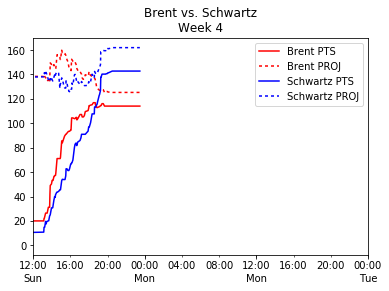

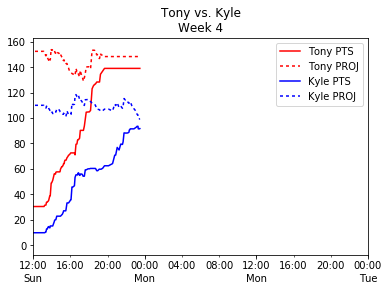

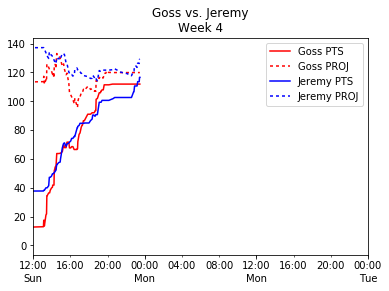

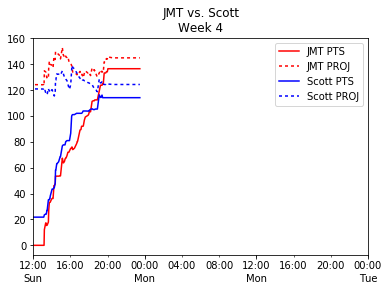

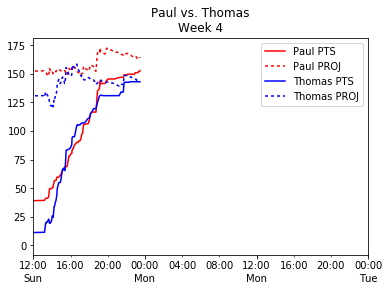

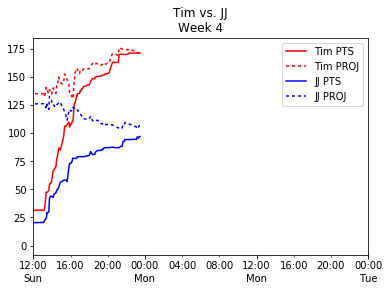

In [5]:
def lambda_handler(input,context):
    post_to_groupme(generate_charts())

lambda_handler(None,None)